In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 13

# Configure Cooridnate

In [2]:
x_arr = np.linspace(-50,50,501)

# Define state function vector

In [3]:
sf_arr = np.empty_like(x_arr, dtype=complex)
from tdse.analytic import Gaussian1D
k_x = 2.0
t = 5.0
# sf_arr[:] = Gaussian1D(x_arr - 20, t=t, k_x=k_x)
sf_arr[:] = Gaussian1D(x_arr, t=t, k_x=k_x)

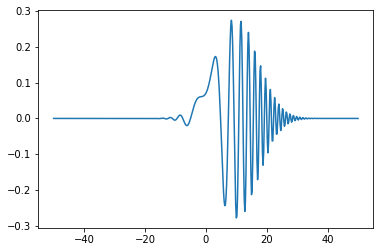

In [4]:
figx, axx = plt.subplots()
axx.plot(x_arr, sf_arr.real)

# Configure Hamiltonian

In [5]:
V_x_arr = np.zeros_like(x_arr, dtype=float)

# Configure window operator

In [6]:
winop_n=1
winop_gamma = 0.01

from nunit import au
au2ev = au.au2si['energy'] / au.e
print("Resolution: {:.2f} eV".format(winop_gamma * au2ev))

Resolution: 0.27 eV


# Construct energy array

In [7]:
E_min_in, E_max_in = -0.5, 1.5
# N_E = 150
# E_arr = E_min + 2*winop_gamma*np.arange(N_E)

# Evaluate energy spectrum from `WINOP`

## Enlarge the spatial grid

In [8]:
from tdse.winop.resol import enlarge_x_arr, enlarge_arr

N_plus = 1000
sf_arr_winop = enlarge_arr(N_plus, sf_arr)
V_x_arr_winop = enlarge_arr(N_plus, V_x_arr)
x_arr_winop = enlarge_x_arr(N_plus, x_arr)

# TEST

In [9]:
from tdse.winop import eval_psi_E_x

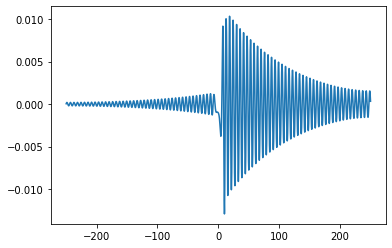

In [10]:
psi_E_x = eval_psi_E_x(sf_arr_winop, x_arr[1] - x_arr[0], V_x_arr_winop, 0.6, winop_n, winop_gamma)

figal, axal = plt.subplots()
axal.plot(x_arr_winop, psi_E_x.real)

## Evaluation

In [11]:
from tdse.winop import eval_energy_spectrum_for_1D_hamil

# spectrum_E_arr = eval_energy_spectrum_for_1D_hamil(
#     sf_arr_winop, x_arr_winop, V_x_arr_winop, E_arr, winop_n, winop_gamma)

spectrum_E_arr, E_arr, spectrum_p_arr, p_arr = eval_energy_spectrum_for_1D_hamil(
    sf_arr_winop, x_arr_winop, V_x_arr_winop, E_min_in, E_max_in, winop_n, winop_gamma, eval_momentum=True)

In [12]:
hbar = 1.0

In [13]:
from tdse.analytic import Gaussian1D_k_t0
psi_k = Gaussian1D_k_t0(p_arr / hbar, k_x)
pdf_k = np.real(psi_k.conj() * psi_k)
pdf_p_ana = 1.0 / hbar * pdf_k

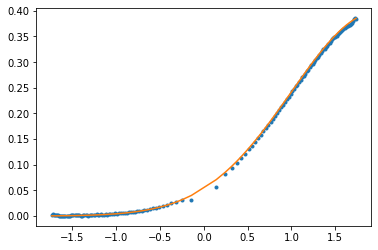

In [14]:
figp, axp = plt.subplots()
axp.plot(p_arr, spectrum_p_arr, '.')

axp.plot(p_arr, pdf_p_ana)

# figp.savefig("momentum-spectrum-test-1.png")

# [TODO] Figure out the reaon for this discrepancy

# [TODO] At p = 0, the probability density is always zero, altough the actual value is not. Figure out why and how to circumvent this difficulty

## [TODO] Animate the WINOP spectra with respect to time - to see the convergence - Start from negative time where some of the state function is located on negative side - Or, start after locating the center of the packet to one side and see the momentum distribituion. It seems to matter

# [TODO] Is it the only possible way to evaluate the momentum-resolved spectrum by setting zero as a divider of integration? .. but zero seems reasonable especially when going spherical or cylinderical coordinate where there is an origin-symmetry

## [TODO] Plot each state function $\psi(x,E)$

## [TODO] Check if $1 / 2\gamma$ is right

## [TODO] Does this satisfies the Nyquist limit? - Consult with the 'Error Analysis' below

### consider .. dividing by gamma

In [15]:
def construct_E_arr_for_winop(E_min_in, E_max_in, gamma):
    _start_ind = int((E_min_in / gamma - 1) // 2)
    _end_ind = - int((-1 - E_max_in / gamma) // (2))
    _E_arr = 2*gamma * np.arange(_start_ind, _end_ind, 1) + gamma
    return _E_arr

In [16]:
construct_E_arr_for_winop(-0.34, 0.55, 2.0)

array([-2.,  2.])

## [TODO] Implement momentum-resolved routine

## [TODO] Check the convergence of momentum spectrum from WINOP

# Comparison to analytical result

In [17]:
pos_E_arr = E_arr[E_arr > 0]
pos_k_arr = np.sqrt(2.0*pos_E_arr)
from tdse.analytic import Gaussian1D_k_t0
spectrum_E_ana_arr = 1.0/pos_k_arr * (
    np.square( np.abs(Gaussian1D_k_t0(pos_k_arr, k_x)) ) 
    + np.square( np.abs(Gaussian1D_k_t0(-pos_k_arr, k_x)) )
)

## Draw

### [TODO] The reason for oscillation in WINOP result

- the oscillation seems to increase its amplitude as gamma get smaller

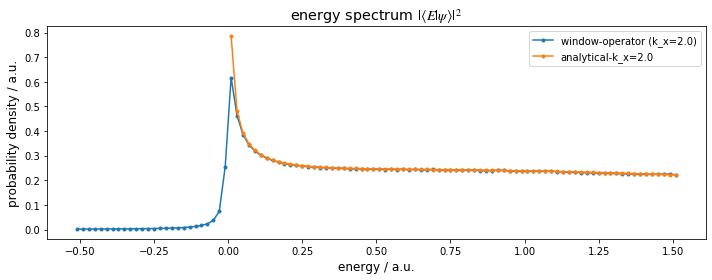

In [18]:
figE, axE = plt.subplots(figsize=(10,4))
li_winop, = axE.plot(E_arr, spectrum_E_arr, '.-')
li_ana, = axE.plot(pos_E_arr, spectrum_E_ana_arr, '.-')

axE.set_title(r"energy spectrum $|{\langle}E|\psi{\rangle}|^2$")
axE.set_xlabel("energy / a.u.")
axE.set_ylabel("probability density / a.u.")
axE.legend(
    (li_winop, li_ana), 
    ("window-operator (k_x={:.1f})".format(k_x), "analytical-k_x={:.1f}".format(k_x)))

figE.tight_layout()

In [19]:
# figE.savefig("winop-analytical-comparison-test-3-oscil-reduced-by-increased-xmax.png")

# Error analysis

In [20]:
from tdse.winop.resol import eval_delta_E

E_max = 1.0
delta_E_max = eval_delta_E(E_max, x_arr_winop)
print("The energy resolution is large enough compared to estimated continuum state density: {}".format(winop_gamma > delta_E_max))
print("window operator gamma: {:.5f} / delta_E: {:.5f}".format(winop_gamma, delta_E_max))

The energy resolution is large enough compared to estimated continuum state density: True
window operator gamma: 0.01000 / delta_E: 0.00891
